
# Лабаораторная работа №1: Аудио EDA и характеристики сигнала

**Цель:** научиться загружать аудиодатасеты, читать и интерпретировать метаданные, вычислять базовые характеристики аудиосигнала и строить визуализации (waveform, спектр, Mel/Log‑Mel).  
**Формат:** заполнить `TODO`‑ячейки. Ячейки с `raise NotImplementedError` необходимо заменить вашим кодом.

**Требования по оформлению графиков:** используйте `matplotlib` (без seaborn), один график на фигуру, не задавайте кастомные цвета.

**Зависимости:** `datasets[audio]`, `librosa`, `numpy`, `matplotlib`, `soundfile`, `tqdm`.


In [ ]:
!pip install datasets[audio] librosa soundfile matplotlib tqdm

In [2]:
# === Установка и импорт (при необходимости раскомментируйте установки) ===

import os, json, random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from datasets import load_dataset, Audio
import librosa, librosa.display
import soundfile as sf

import warnings; warnings.filterwarnings('ignore')

SEED = 42
random.seed(SEED); np.random.seed(SEED)



## Задание 1. Выбор и загрузка датасета(ов)

**Варианты:**
- Речь (например, `PolyAI/minds14`, любая локаль).
- Звуки окружения (любой датасет на HF Hub или локальная папка WAV/FLAC).

**Что сделать:**
1. Указать идентификатор/путь датасета.
2. Загрузить сплит (например, `train` или подвыборку).
3. Показать структуру фич и пример записи.


In [3]:
DATASET_ID = "PolyAI/minds14"   
DATASET_CONFIG = "en-AU"       
DATASET_SPLIT = "train"         

try:
    ds = load_dataset(DATASET_ID, name=DATASET_CONFIG, split=DATASET_SPLIT)
    ds = ds.cast_column("audio", Audio())  # декодируем аудио
except Exception as e:
    print("Не удалось загрузить датасет через load_dataset:", e)
    ds = None


In [37]:
def preview(ds, n=1):
    if ds is None:
        print("Dataset is None")
        return
    print(ds)
    d = ds.select(range(n)).to_dict()
    examples = [{k: d[k][i] for k in d} for i in range(n)]
    for i, ex in enumerate(examples):
        print(f"Пример {i}:")
        print(ex)

preview(ds, n=1)

Dataset({
    features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
    num_rows: 654
})
Пример 0:
{'path': 'en-AU~PAY_BILL/response_4.wav', 'audio': {'bytes': b'RIFF\x02\xf4\x00\x00WAVEfmt \x12\x00\x00\x00\x07\x00\x01\x00@\x1f\x00\x00@\x1f\x00\x00\x01\x00\x08\x00\x00\x00fact\x04\x00\x00\x00\xcf\xf3\x00\x00data\xcf\xf3\x00\x00\xff\xfe~\xff\xff\xff\xfe\xff\xff\xff\xff\xff\xff\xff\xff\xfe~\xff~\xff\xff\xff\xff\xff\xff~\xff\xff\xfe\xff\xff\xff\xfe\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff\xff~\xff\xff\xff\xff\xff~~~\xff\xff\xfe~\xff\xff\xff\xff\xff\xff\xff\xfe\xff\xfe\xfe~\xff\xff\xff\xfe\xff\xff\xfe\xff~\xff\xff\xff~\xff\xff\xff\xfe\xff\xff~\xff\xff\xfe\xff\xfe\xff\xfe\xff\xff~~\xff\xff\xff\xff\xff\xfe~\xff\xff\xff~\xff\xff\xff\xff\xff\xff\xff\xff\xff\xfe\xfe\xff\xff\xff\xfe~}~\xfd\xfc|z~\xfd}yy|\xffzw|\xfd\xfe||\xfc\xf8\xfb~\xf9\xf0\xf1\xf6\xf8\xf1\xea\xeb\xf4\xf6\xee\xe9\xe9\xf1}\xfa\xee\xf3{nlpmc`ba^[[_b^\\^cknnq|\xf8\xee\xe9\xe6\xe3\xe1\x


## Задание 2. Базовые характеристики аудиосигнала

**Что посчитать для N примеров:**
- Частота дискретизации (SR), длительность (с), количество каналов.
- Пиковый уровень (max |x|), RMS‑уровень, оценка динамического диапазона (приближенно).
- Коэффициент клиппинга (% сэмплов с |x|≈1.0 при float или на границе int).
- Zero‑Crossing Rate (ZCR), спектральный центроид и полосa (bandwidth).
- (Опционально) Оценка SNR при простой модели шума (на ваш выбор).

**Вывести:**
- Сводную таблицу (словари/списки), а также агрегаты: mean/median/p95.


In [ ]:
def num_channels(arr: np.ndarray) -> int:
    """Возвращает количество каналов (1 для моно)."""
    if arr.ndim == 1:
        return 1
    # Если многоканальное аудио (2D)
    if arr.ndim == 2:
        # shape: (samples, channels) или (channels, samples)
        return np.min(arr)
    return 1

def peak_level(arr: np.ndarray) -> float:
    """Пиковый уровень max |x| для float в [-1, 1]."""
    return float(np.max(np.abs(arr)))

def rms_level(arr: np.ndarray) -> float:
    """RMS-уровень сигнала."""
    return float(np.sqrt(np.mean(arr ** 2)))

def clipping_ratio(arr: np.ndarray, thr: float = 0.999) -> float:
    """Доля сэмплов близких к клиппингу (|x| >= thr)."""
    clipped = np.sum(np.abs(arr) >= thr)
    return float(clipped) / arr.size

def zero_crossing_rate(arr: np.ndarray) -> float:
    """Оценка ZCR (число пересечений нуля / длина)."""
    if arr.ndim > 1:
        arr = np.mean(arr, axis=1) if arr.shape[0] <= 8 else np.mean(arr, axis=0)
    signs = np.sign(arr)
    sign_changes = np.diff(signs)
    zero_crossings = np.sum(sign_changes != 0)
    return float(zero_crossings) / len(arr)

def spectral_stats(arr: np.ndarray, sr: int):
    """Спектральные признаки: центроид и полоса (bandwidth)."""
    if arr.ndim > 1:
        arr = librosa.to_mono(arr)
    centroid = librosa.feature.spectral_centroid(y=arr, sr=sr).mean()
    bandwidth = librosa.feature.spectral_bandwidth(y=arr, sr=sr).mean()
    return {'centroid': float(centroid), 'bandwidth': float(bandwidth)}

def duration_seconds(arr: np.ndarray, sr: int) -> float:
    """Длительность аудио в секундах."""
    return len(arr) / float(sr)
import io

def bytes_to_audio_dict(audio_dict):
    data = audio_dict.get("bytes")
    if data is None:
        return None, None
    try:
        arr, sr = sf.read(io.BytesIO(data), dtype='float32')
        if arr.ndim > 1 and arr.shape[1] == 1:
            arr = arr[:, 0]
        return arr, sr
    except Exception as e:
        print(f"Ошибка декодирования аудио: {e}")
        return None, None



In [ ]:
N = 200 
metrics = []

if ds is not None:
    idxs = np.random.choice(len(ds), size=min(N, len(ds)), replace=False)
    subset = ds.select(list(idxs))
    df = subset.to_pandas()
    for _, ex in tqdm(df.iterrows(), total=len(df), desc="Computing metrics"):
        aud = ex.get("audio", {})
        arr, sr = bytes_to_audio_dict(aud)
        if arr is None or sr is None:
            continue
        if isinstance(arr, np.ndarray) and arr.ndim > 1:
            arr = librosa.to_mono(arr)
        m = {
            "sr": sr,
            "dur_s": duration_seconds(arr, sr),
            "channels": num_channels(arr),
            "peak": peak_level(arr),
            "rms": rms_level(arr),
            "clip_ratio": clipping_ratio(arr),
            "zcr": zero_crossing_rate(arr),
        }
        sc = spectral_stats(arr, sr)
        if isinstance(sc, dict):
            m.update(sc)
        metrics.append(m)

print(f"Собрано {len(metrics)} метрик")
print(metrics[:3])  


Computing metrics: 100%|██████████| 200/200 [00:20<00:00,  9.77it/s]

Собрано 200 метрик
[{'sr': 8000, 'dur_s': 5.034625, 'channels': 1, 'peak': 0.1483154296875, 'rms': 0.013663651421666145, 'clip_ratio': 0.0, 'zcr': 0.31772475606425504, 'centroid': 1389.7933970478189, 'bandwidth': 992.1274978746544}, {'sr': 8000, 'dur_s': 13.141375, 'channels': 1, 'peak': 0.4725341796875, 'rms': 0.022827381268143654, 'clip_ratio': 0.0, 'zcr': 0.37499881100721955, 'centroid': 1543.673911375999, 'bandwidth': 1023.0740498576731}, {'sr': 8000, 'dur_s': 5.290625, 'channels': 1, 'peak': 0.1326904296875, 'rms': 0.014897333458065987, 'clip_ratio': 0.0, 'zcr': 0.28040165386887184, 'centroid': 1258.788622037854, 'bandwidth': 919.3547267888775}]


In [ ]:
import numpy as np

def agg(values):
    if not values: return {"mean": None, "median": None, "p95": None}
    arr = np.array(values, dtype=float)
    return {"mean": float(np.mean(arr)), "median": float(np.median(arr)), "p95": float(np.percentile(arr, 95))}

def summarize(metrics):
    keys = [k for k in metrics[0].keys() if isinstance(metrics[0][k], (int, float))]
    summary = {}
    for k in keys:
        summary[k] = agg([m[k] for m in metrics if m.get(k) is not None])
    return summary

if metrics:
    summary = summarize(metrics)
    print(json.dumps(summary, indent=2, ensure_ascii=False))
else:
    print("Нет метрик для сводки — проверьте загрузку/вычисления.")


{
  "sr": {
    "mean": 8000.0,
    "median": 8000.0,
    "p95": 8000.0
  },
  "dur_s": {
    "mean": 8.06415,
    "median": 6.4,
    "p95": 17.86030624999996
  },
  "channels": {
    "mean": 1.0,
    "median": 1.0,
    "p95": 1.0
  },
  "peak": {
    "mean": 0.54173828125,
    "median": 0.5740966796875,
    "p95": 0.8865966796875
  },
  "rms": {
    "mean": 0.052170474615413694,
    "median": 0.045779718086123466,
    "p95": 0.10956793576478957
  },
  "clip_ratio": {
    "mean": 0.0,
    "median": 0.0,
    "p95": 0.0
  },
  "zcr": {
    "mean": 0.2779094616031672,
    "median": 0.2794243588947166,
    "p95": 0.38181807077780683
  },
  "centroid": {
    "mean": 1330.482303559425,
    "median": 1349.6129862786042,
    "p95": 1637.3543179588917
  },
  "bandwidth": {
    "mean": 977.459428688903,
    "median": 991.2641729368723,
    "p95": 1090.9315553843376
  }
}



## Задание 3. Визуализация: waveform, спектр, Mel/Log‑Mel

**Что сделать:**
1. Построить waveform для нескольких примеров (ось x — время, y — амплитуда).
2. STFT‑спектрограмму в dB (логарифмическая шкала по амплитуде).
3. Mel‑спектрограмму и Log‑Mel при разных параметрах (`n_fft`, `hop_length`, `n_mels`, `fmax`, `htk/slaney`).
4. Сравнить как минимум 3 конфигурации и описать наблюдения в тексте.


In [ ]:
def plot_waveform(arr, sr, title="Waveform"):
    plt.figure()
    librosa.display.waveshow(arr, sr=sr)
    plt.title(title); plt.xlabel("Time"); plt.ylabel("Amplitude"); plt.show()

def plot_spectrogram_db(arr, sr, n_fft=2048, hop_length=512, title="Spectrogram (dB)"):
    import numpy as np
    D = librosa.stft(arr, n_fft=n_fft, hop_length=hop_length)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    plt.figure()
    librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz')
    plt.title(title); plt.colorbar(); plt.show()

def plot_mel_logmel(arr, sr, n_fft=2048, hop_length=512, n_mels=80, fmax=None, htk=False, title_prefix="Mel"):
    mel = librosa.feature.melspectrogram(y=arr, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, fmax=fmax, htk=htk)
    logmel = librosa.power_to_db(mel, ref=np.max)
    plt.figure()
    librosa.display.specshow(logmel, sr=sr, x_axis='time', y_axis='mel', hop_length=hop_length)
    plt.title(f"{title_prefix}: log-Mel (n_mels={n_mels}, htk={htk})"); plt.colorbar(); plt.show()
    return mel, logmel


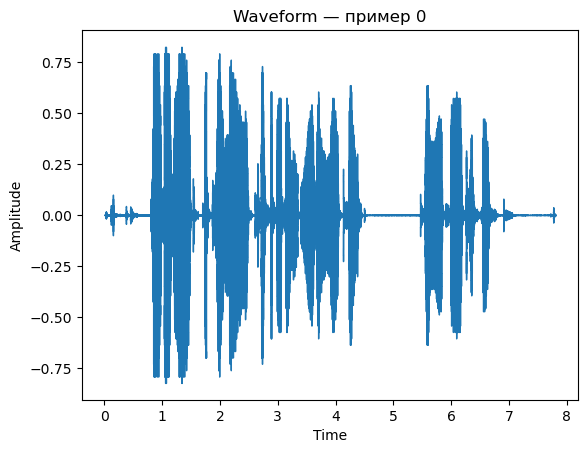

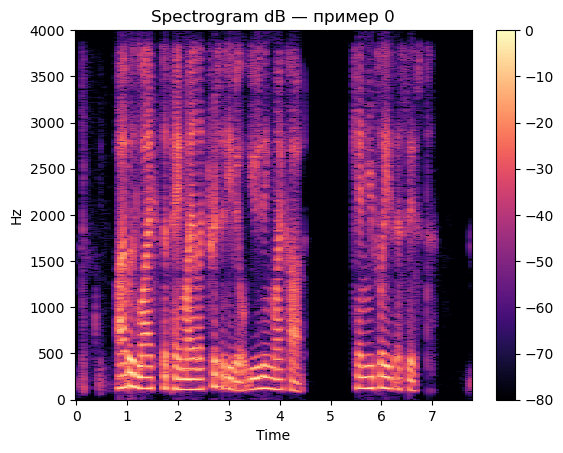

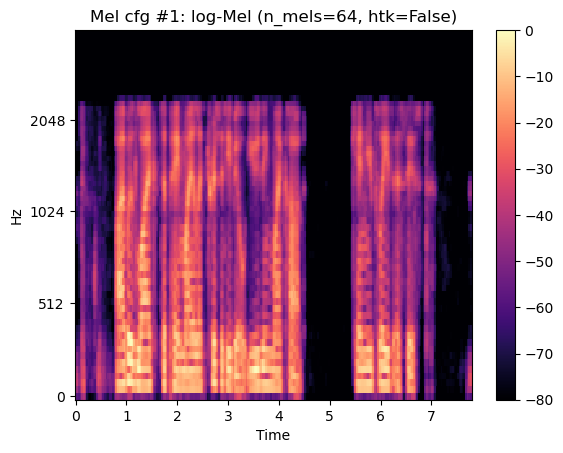

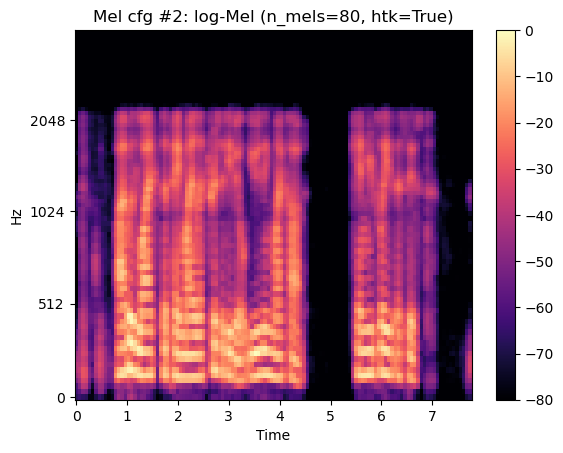

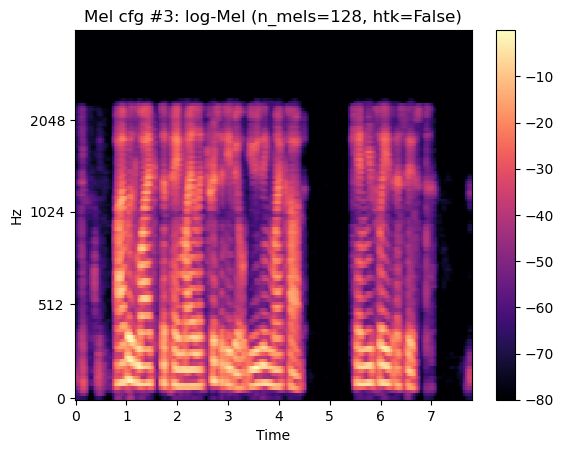

In [ ]:
if ds is not None and len(ds) > 0:
    example_dict = ds.select([0]).to_dict()
    ex = {k: example_dict[k][0] for k in example_dict}
    
    arr, sr = bytes_to_audio_dict(ex['audio'])
    if arr is not None and sr is not None:
        plot_waveform(arr, sr, title="Waveform — пример 0")
        plot_spectrogram_db(arr, sr, n_fft=2048, hop_length=512, title="Spectrogram dB — пример 0")
        cfgs = [
            dict(n_fft=1024, hop_length=256, n_mels=64, fmax=8000, htk=False),
            dict(n_fft=2048, hop_length=512, n_mels=80, fmax=8000, htk=True),
            dict(n_fft=2048, hop_length=256, n_mels=128, fmax=8000, htk=False),
        ]
        for i, cfg in enumerate(cfgs):
            plot_mel_logmel(arr, sr, **cfg, title_prefix=f"Mel cfg #{i+1}")
else:
    print("Датасет пуст или не загружен.")



## Задание 4. Передискретизация и сравнение (resampling)


1. Передискретизировать сигнал до 16 kHz (если исходно другой SR) и сравнить waveform/спектры до/после.
2. Посчитать Nyquist‑частоту для обеих SR и обсудить, какие частоты потенциально теряются.
3. Оценить влияние `hop_length` при фиксированном `n_fft` на временное/частотное разрешение.


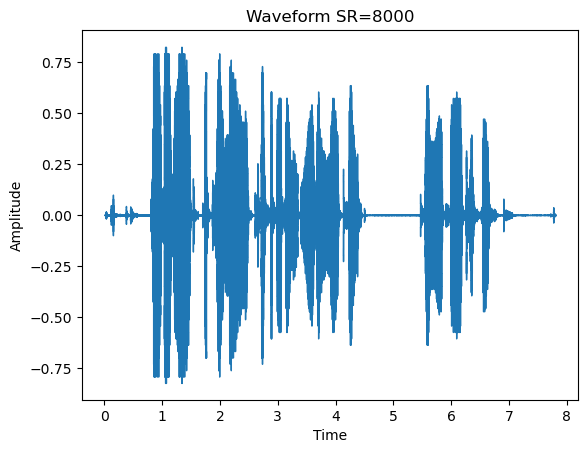

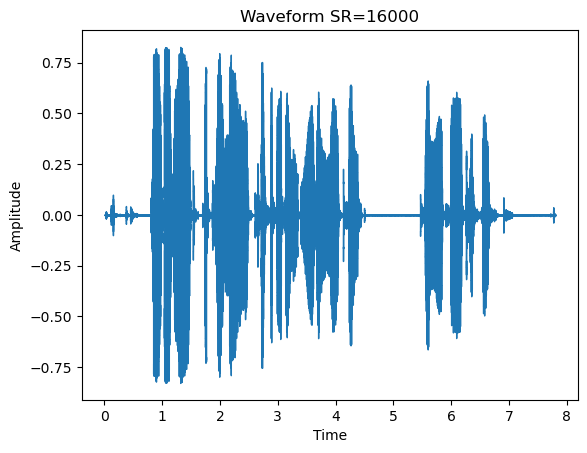

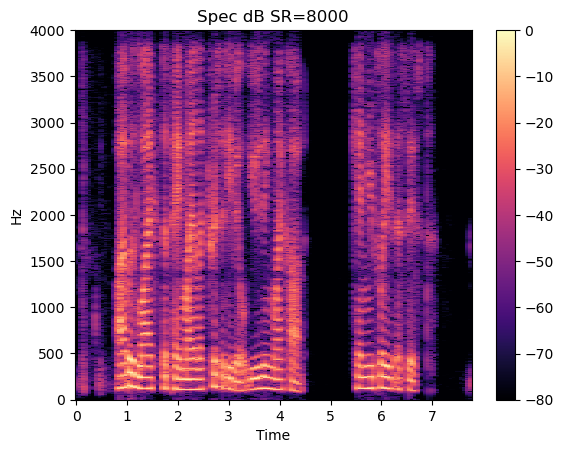

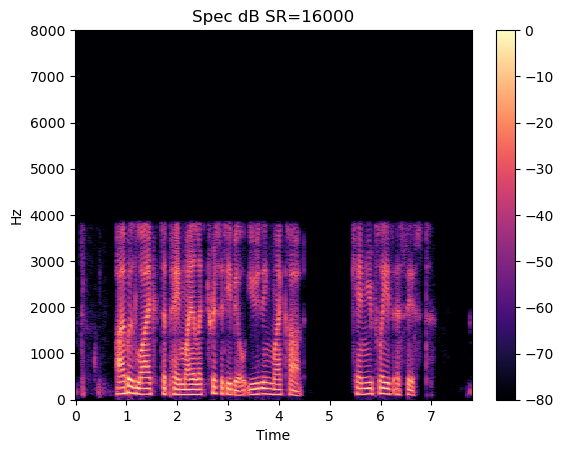

Nyquist исходный: 4000.0 Hz; после: 8000.0 Hz


In [ ]:
TARGET_SR = 16_000

def resample(arr, sr, target_sr=TARGET_SR):
    if sr == target_sr:
        return arr, sr
    arr_resampled = librosa.resample(arr, orig_sr=sr, target_sr=target_sr)
    return arr_resampled, target_sr

def nyquist(sr):
    return sr / 2.0

if ds is not None and len(ds) > 0:
    example_dict = ds.select([0]).to_dict()
    ex = {k: example_dict[k][0] for k in example_dict}
    arr, sr = bytes_to_audio_dict(ex['audio']) 
  
    if arr is not None and sr is not None:
        arr2, sr2 = resample(arr, sr, TARGET_SR)
        plot_waveform(arr, sr, title=f"Waveform SR={sr}")
        plot_waveform(arr2, sr2, title=f"Waveform SR={sr2}")
        plot_spectrogram_db(arr, sr, title=f"Spec dB SR={sr}")
        plot_spectrogram_db(arr2, sr2, title=f"Spec dB SR={sr2}")
        print("Nyquist исходный:", nyquist(sr), "Hz; после:", nyquist(sr2), "Hz")
else:
    print("Датасет пуст или не загружен.")




## Задание 5. Dataset‑level EDA

1. Построить распределения длительностей, SR, пиковых уровней (гистограммы).
2. (Если есть метки классов) — подсчитать число примеров по классам.
3. Сформировать короткие выводы о качестве сырого датасета (наличие очень коротких/длинных записей, клиппинг и пр.).


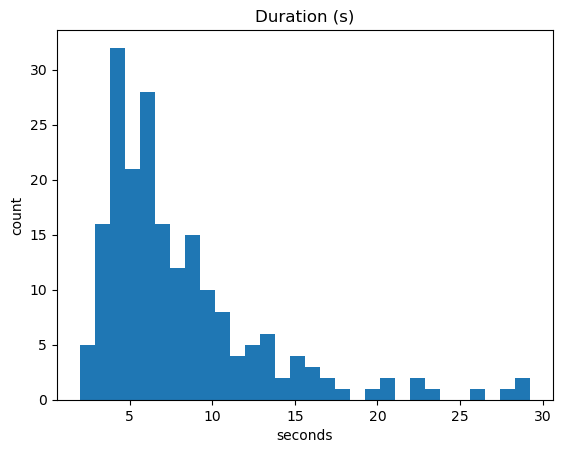

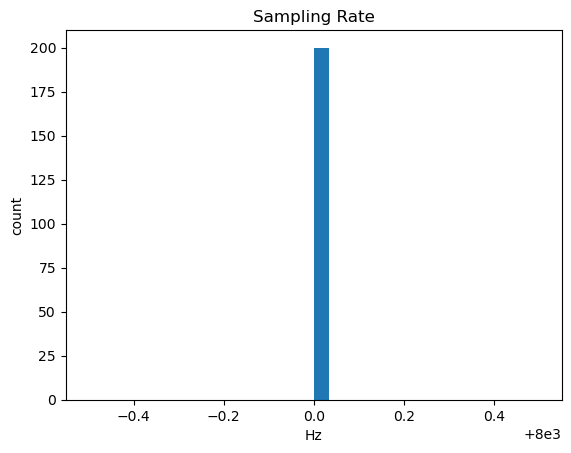

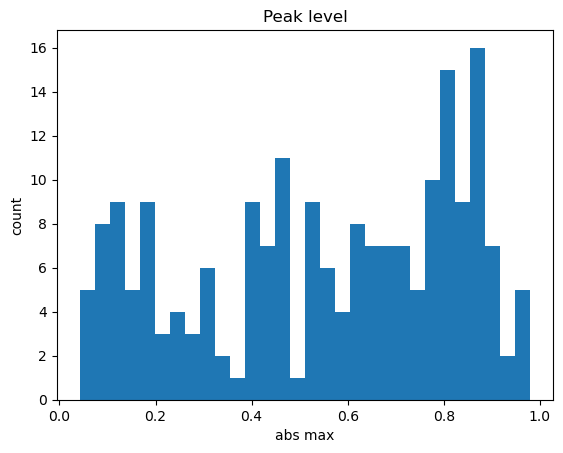

Длина записей варьируется от 1.96 до 29.27 секунд.
Максимальный уровень пиков: до 0.00 (чем ближе к 1, тем больше клиппинга).


In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

def hist(values, bins=30, title="Histogram", xlabel="value"):
    plt.figure()
    plt.hist(values, bins=bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("count")
    plt.show()

if metrics:
    hist([m['dur_s'] for m in metrics if m.get('dur_s') is not None], title="Duration (s)", xlabel="seconds")
    hist([m['sr'] for m in metrics if m.get('sr') is not None], title="Sampling Rate", xlabel="Hz")
    hist([m['peak'] for m in metrics if m.get('peak') is not None], title="Peak level", xlabel="abs max")
    
    if 'intent_class' in metrics[0]:
        classes = [m['intent_class'] for m in metrics if m.get('intent_class') is not None]
        counter = Counter(classes)
        print("Распределение по классам:")
        for cls, cnt in counter.items():
            print(f"  Класс {cls}: {cnt} объектов")
        
        plt.figure()
        plt.bar(counter.keys(), counter.values())
        plt.title("Распределение по классам")
        plt.xlabel("Класс")
        plt.ylabel("Количество")
        plt.show()

    # вывод по качеству
    durations = [m['dur_s'] for m in metrics if 'dur_s' in m]
    peak_ratios = [m['clip_ratio'] for m in metrics if 'clip_ratio' in m]
    print(f"Длина записей варьируется от {min(durations):.2f} до {max(durations):.2f} секунд.")
    print(f"Максимальный уровень пиков: до {max(peak_ratios):.2f} (чем ближе к 1, тем больше клиппинга).")
else:
    print("Метрики отсутствуют — проверьте сбор данных.")
